In [1]:
import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import datasets, layers, models, backend
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import IPython.display as display
import pathlib


In [2]:
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [3]:
# fetch data and store

In [4]:
train_images = pathlib.Path('H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_train\\')

train_images_list = list(train_images.glob('*.png'))
train_images = []
for image in train_images_list:
    train_images.append(str(image))
    
val_images =   pathlib.Path('H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_validate\\')

val_images_list = list(val_images.glob('*.png'))
val_images = []
for image in val_images_list:
    val_images.append(str(image))
    
test_images =  pathlib.Path('H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_test\\')

test_images_list = list(test_images.glob('*.png'))
test_images = []
for image in test_images_list:
    test_images.append(str(image))
    
train_labels = pathlib.Path('H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_seg_train\\')

train_labels_list = list(train_labels.glob('*.png'))
train_labels = []
for label in train_labels_list:
    train_labels.append(str(label))

    
val_labels =   pathlib.Path('H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_seg_validate\\')

val_labels_list = list(val_labels.glob('*.png'))
val_labels = []
for label in val_labels_list:
    val_labels.append(str(label))
    
test_labels =  pathlib.Path('H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_seg_test\\')

test_labels_list = list(test_labels.glob('*.png'))
test_labels = []
for label in test_labels_list:
    test_labels.append(str(label))
    


In [5]:
# pair image with label

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [6]:
# shuffle

train_ds = train_ds.shuffle(len(train_images))
val_ds = val_ds.shuffle(len(val_images))

In [7]:
def get_a_palette(img):
    list0 = get_arr_list(img)
    palette = get_palette(list0)
    return palette

# img.shape = (256,256,4)
def get_arr_list(img):
    list0= []
    for i in range(IMG_HEIGHT):
        for j in range(IMG_HEIGHT):
            list0.append(img[i,j,:].tolist())
    return list0

def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item


def sort_and_deduplicate(l):
    return list(uniq(sorted(l, reverse=True)))

def get_palette(lst):
    palette = sort_and_deduplicate(lst)
    return palette

def decode_img(img):
    img = tf.image.decode_png(img, channels=4) #color images
#     img / 255.0
    img = tf.image.convert_image_dtype(img, tf.float32)
    #convert unit8 tensor to floats in the [0,1]range
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 
    #resize the image into 32*32 
    

def ohm(palette, img):
    one_hot_map = []
    for colour in palette:
        class_map = tf.reduce_all(tf.equal(img, colour), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)
    return one_hot_map



In [8]:
# get palette
file_path1 = train_labels[0]
img = tf.io.read_file(file_path1)
decoded_image = decode_img(img)
palette = get_a_palette(decoded_image.numpy())
palette

[[1.0, 1.0, 1.0, 1.0],
 [0.6666666865348816, 0.6666666865348816, 0.6666666865348816, 1.0],
 [0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 1.0],
 [0.0, 0.0, 0.0, 1.0]]

In [9]:
#  both paths are to an image
def map_fn(image_path, label_path):
    # Load the raw data from the file as a string.
    img = tf.io.read_file(image_path)
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_png(img, channels=4) # channels=3 for RGB, channels=1 for grayscale
    # Resize the image to the desired size.
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 
    # Standardise values to be in the [0, 1] range.
    img = tf.cast(img, tf.float32) / 255.0
    # One-hot encode the label.
    label1 = tf.io.read_file(label_path)
    label2 = decode_img(label1)
    one_hot = ohm(palette, label2)
    # Return the processed image and label.
    return img, one_hot

In [10]:
# Use Dataset.map to apply this transformation.
train_ds = train_ds.map(map_fn)
val_ds = val_ds.map(map_fn)
test_ds = test_ds.map(map_fn)

In [11]:
for image, label in train_ds.take(1):
    print('Image shape:', image.numpy().shape)

Image shape: (256, 256, 4)


Image: AxesImage(54,36;334.8x217.44)


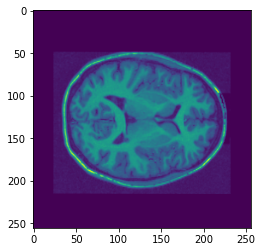

In [12]:
for image, label in train_ds.take(1):
    print('Image:', plt.imshow(image[:,:,2]))

Label: AxesImage(54,36;334.8x217.44)


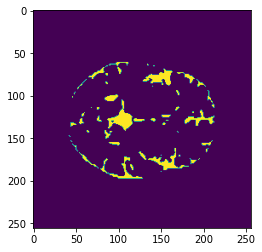

In [13]:
for image, label in train_ds.take(1):
    print('Label:', plt.imshow(label[:,:,2]))

In [14]:
label_test = tf.io.read_file(train_labels[1])
# label_test

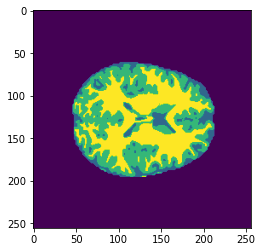

In [15]:
img = decode_img(label_test)
plt.imshow(img.numpy()[:,:,2])

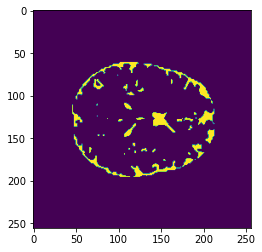

In [16]:
ohm_test = ohm(palette, img)
plt.imshow(ohm_test[:,:,2])

In [17]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_HEIGHT, 4), name="img")

# 3x3x3 conv
precontext1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same")(inputs)

# context module 1 
# context module = conv2d 3x3x3 + droput(0.3) + conv2d 3x3x3
context1 = tf.keras.layers.BatchNormalization()(precontext1)
context1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same")(context1)
context1 = tf.keras.layers.Dropout(0.3)(context1)
context1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same")(context1)
# context1 = tf.keras.layers.LeakyReLU(alpha=0.1)(context1)


# combine pre-context and post-context
net1 = tf.keras.layers.Add()([precontext1, context1])
copy1 = net1

# downsample 1 using stride instead of max2d
precontext2 = tf.keras.layers.BatchNormalization()(net1)
precontext2 = tf.keras.layers.Conv2D(32, (3,3), strides=(2,2), activation="relu", padding="same")(precontext2)
# precontext2 = tf.keras.layers.LeakyReLU(alpha=0.1)(precontext2)


# context module 2 
# context module = conv2d 3x3x3 + droput(0.3) + conv2d 3x3x3
context2 = tf.keras.layers.BatchNormalization()(precontext2)
context2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(context2)
context2 = tf.keras.layers.Dropout(0.3)(context2)
context2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(context2)
# context2 = tf.keras.layers.LeakyReLU(alpha=0.1)(context2)



# combine pre-context and post-context
net2 = tf.keras.layers.Add()([precontext2, context2])
copy2 = net2

# downsample 2 using stride instead of max2d
precontext3 = tf.keras.layers.BatchNormalization()(net2)
precontext3 = tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), activation="relu", padding="same")(precontext3)
# precontext3 = tf.keras.layers.LeakyReLU(alpha=0.1)(precontext3)

# context module 3
# context module = conv2d 3x3x3 + droput(0.3) + conv2d 3x3x3
context3 = tf.keras.layers.BatchNormalization()(precontext3)
context3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(context3)
context3 = tf.keras.layers.Dropout(0.3)(context3)
context3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(context3)
context3 = tf.keras.layers.LeakyReLU(alpha=0.1)(context3)



# combine pre-context and post-context
net3 = tf.keras.layers.Add()([precontext3, context3])
copy3 = net3


# downsample 3 using stride instead of max2d
precontext4 = tf.keras.layers.BatchNormalization()(net3)
precontext4 = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), activation="relu", padding="same")(precontext4)
# precontext4 = tf.keras.layers.LeakyReLU(alpha=0.1)(precontext4)



# context module 4
# context module = conv2d 3x3x3 + droput(0.3) + conv2d 3x3x3
context4 = tf.keras.layers.BatchNormalization()(precontext4)
context4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(context4)
context4 = tf.keras.layers.Dropout(0.3)(context4)
context4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(context4)
# context4 = tf.keras.layers.LeakyReLU(alpha=0.1)(context4)



# combine pre-context and post-context
net4 = tf.keras.layers.Add()([precontext4, context4])
copy4 = net4

# downsample 4 using stride instead of max2d
precontext5 = tf.keras.layers.BatchNormalization()(net4)
precontext5 = tf.keras.layers.Conv2D(256, (3,3), strides=(2,2), activation="relu", padding="same")(precontext5)
# precontext5 = tf.keras.layers.LeakyReLU(alpha=0.1)(precontext5)



# context module 5
# context module = conv2d 3x3x3 + droput(0.3) + conv2d 3x3x3
context5 = tf.keras.layers.BatchNormalization()(precontext5)
context5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", padding="same")(context5)
context5 = tf.keras.layers.Dropout(0.3)(context5)
context5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", padding="same")(context5)
context5 = tf.keras.layers.LeakyReLU(alpha=0.1)(context5)



# combine pre-context and post-context
net5 = tf.keras.layers.Add()([precontext5, context5])

# upsample 1
# upsample module = upsample2d + conv2d
upsample1 = tf.keras.layers.UpSampling2D()(net5)
upsample1 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(upsample1)
# upsample1 = tf.keras.layers.LeakyReLU(alpha=0.1)(upsample1)


# concat copy4 and upsample1
prelocal1 = tf.keras.layers.concatenate([copy4, upsample1])


# localization module 1
# localization module = conv2d 3x3x3 + conv2d 1x1x1
local1 = tf.keras.layers.BatchNormalization()(prelocal1)
local1 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(local1)
local1 = tf.keras.layers.Conv2D(128, (1,1), activation="relu", padding="same")(local1)
# local1 = tf.keras.layers.LeakyReLU(alpha=0.01)(local1)

# upsample 2
# upsample module = upsample2d + conv2d
upsample2 = tf.keras.layers.UpSampling2D()(local1)
upsample2 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(upsample2)
# upsample2 = tf.keras.layers.LeakyReLU(alpha=0.01)(upsample2)


# concat copy3 and upsample2
prelocal2 = tf.keras.layers.concatenate([copy3, upsample2])


# localization module 2
# localization module = conv2d 3x3x3 + conv2d 1x1x1
local2 = tf.keras.layers.BatchNormalization()(prelocal2)
local2 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(local2)
local2 = tf.keras.layers.Conv2D(64, (1,1), activation="relu", padding="same")(local2)
local2 = tf.keras.layers.LeakyReLU(alpha=0.01)(local2)


# segmentation 1/upscale
seg1 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(local2)
seg1 = tf.keras.layers.UpSampling2D()(seg1)


# upsample 3
# upsample module = upsample2d + conv2d
upsample3 = tf.keras.layers.UpSampling2D()(local2)
upsample3 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(upsample3)
# upsample3 = tf.keras.layers.LeakyReLU(alpha=0.01)(upsample3)


# concat copy2 and upsample3
prelocal3 = tf.keras.layers.concatenate([copy2, upsample3])


# localization module 3
# localization module = conv2d 3x3x3 + conv2d 1x1x1
local3 = tf.keras.layers.BatchNormalization()(prelocal3)
local3 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(local3)
local3 = tf.keras.layers.Conv2D(32, (1,1), activation="relu", padding="same")(local3)
# local3 = tf.keras.layers.LeakyReLU(alpha=0.01)(local3)



# segmentation 2/upscale
seg2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(local3)
# seg2 = tf.keras.layers.UpSampling2D()(seg2)


# combine seg1 and seg2
seg1_2 = tf.keras.layers.Add()([seg1, seg2])
seg1_2 = tf.keras.layers.UpSampling2D()(seg1_2)



# upsample 4
# upsample module = upsample2d + conv2d
upsample4 = tf.keras.layers.UpSampling2D()(local3)
upsample4 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same")(upsample4)
# upsample4 = tf.keras.layers.LeakyReLU(alpha=0.01)(upsample4)


# concat copy1 and upsample4
pre_final = tf.keras.layers.concatenate([copy1, upsample4])
pre_final = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(pre_final)


# segmentation 3
pre_final = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(pre_final)
seg_final = tf.keras.layers.Add()([pre_final, seg1_2])


outputs = tf.keras.layers.Conv2D(4, 1, activation="softmax")(seg_final)
model = tf.keras.Model(inputs, outputs, name="unet")
model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 592         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
_______________________________________________________________________________________________

In [18]:
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = tf.keras.backend.batch_flatten(y_true)
    y_pred_f = tf.keras.backend.batch_flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    sums = tf.keras.backend.sum(tf.keras.backend.square(y_true_f)) + tf.keras.backend.sum(tf.keras.backend.square(y_pred_f))

    return (2.0 * intersection + smooth) / (sums + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)
#     img = tf.cast(img, tf.float32) / 255.0
#     loss = 1-dice_coef(y_true, y_pred)
#     output = tf.cast(loss, tf.float32)
#     return output



In [19]:
model.compile(optimizer="adam", loss=dice_coef_loss, metrics=[dice_coef])
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [20]:
history = model.fit(train_ds.batch(32), # using a batch size of 32
                    validation_data=val_ds.batch(32),
                    epochs=10)

Train for 302 steps, validate for 35 steps
Epoch 1/10
302/302 [==============================] - 166s 549ms/step - loss: 0.0919 - dice_coef: 0.9081 - val_loss: 0.3391 - val_dice_coef: 0.6609
Epoch 2/10
302/302 [==============================] - 142s 469ms/step - loss: 0.0825 - dice_coef: 0.9175 - val_loss: 0.0904 - val_dice_coef: 0.9096
Epoch 3/10
302/302 [==============================] - 109s 362ms/step - loss: 0.0818 - dice_coef: 0.9182 - val_loss: 0.0812 - val_dice_coef: 0.9188
Epoch 4/10
302/302 [==============================] - 136s 450ms/step - loss: 0.0815 - dice_coef: 0.9185 - val_loss: 0.0806 - val_dice_coef: 0.9194
Epoch 5/10
302/302 [==============================] - 127s 420ms/step - loss: 0.0813 - dice_coef: 0.9187 - val_loss: 0.0806 - val_dice_coef: 0.9194
Epoch 6/10
302/302 [==============================] - 105s 346ms/step - loss: 0.0812 - dice_coef: 0.9188 - val_loss: 0.0806 - val_dice_coef: 0.9194
Epoch 7/10
302/302 [==============================] - 144s 477ms/step

In [68]:
image_test, label_test = next(iter(test_ds.batch(11)))
prediction = model.predict(image_test)
pred1 = ohm(palette, prediction)

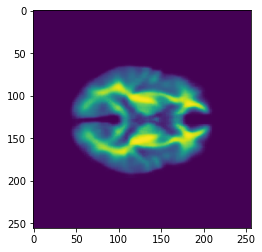

In [69]:
plt.imshow(prediction[0][:,:,0])

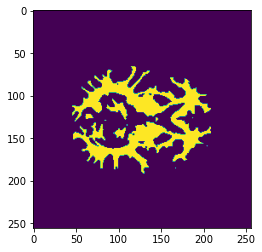

In [73]:
plt.imshow(label_test[0][:,:,0])

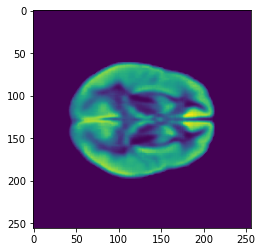

In [74]:
plt.imshow(prediction[0][:,:,1])

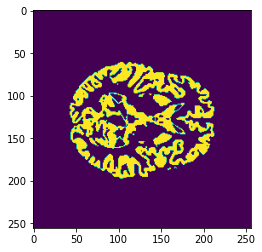

In [76]:
plt.imshow(label_test[0][:,:,1])

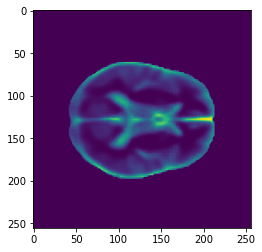

In [77]:
plt.imshow(prediction[0][:,:,2])

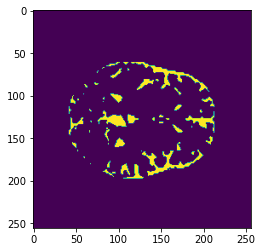

In [78]:
plt.imshow(label_test[0][:,:,2])

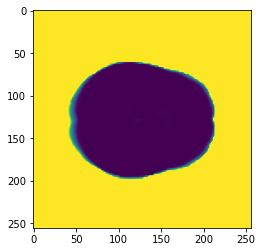

In [79]:
plt.imshow(prediction[0][:,:,3])

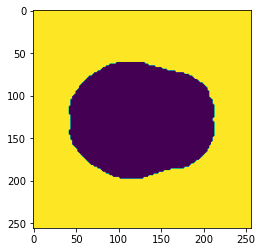

In [80]:
plt.imshow(label_test[0][:,:,3])

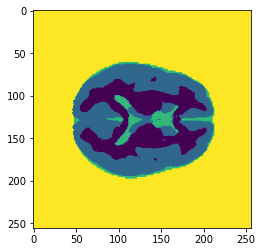

In [81]:
plt.imshow(tf.argmax(prediction[0],axis=-1))

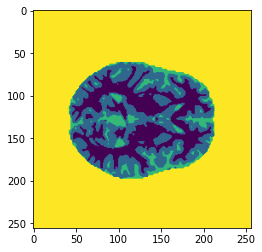

In [82]:
plt.imshow(tf.argmax(label_test[0],axis=-1))